# Vamos a leer el tods yprocesar por autogluon

vamos por paso

En este caso no voy a generar las covariables que generó Daiana

Voy a probar que corra, si corre luego le agrego las variables y veo los cambios en Kaggle




## Preparo todo

In [1]:
### me preparo en el entorno
# entorno
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    #FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    #DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    FUENTES_DIR = '/content/drive/MyDrive/MCD/Labo3/FUENTES/' # Ajustar según usuario
    DATOS_DIR = '/content/drive/MyDrive/MCD_grupo17_la_desgracia/lab3/PruebasAK/DATOSL3/' # ajustar según usuario OJO crear un acceso directo para poder "montar" una unidad compartida
else:
    # configuración para notebook con instalación LOCAL
    # FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = './DATOS/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Mounted at /content/drive/


In [2]:
## Cargo lo necesario
# Cargo paquetes
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from numpy.polynomial import Polynomial
#from scipy.signal import detrend



#import holidays

#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib')

In [3]:
!pip install autogluon.timeseries

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.4/382.4 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import nbformat
from autogluon.timeseries import TimeSeriesPredictor
from autogluon.timeseries import TimeSeriesDataFrame
import autogluon
from autogluon.core.metrics import make_scorer

## Levanto el dataset
vamos a hacer el promedio de los últimos 12 meses por producto

In [5]:
# me traigo el archivo ya procesado con la duración completa
df_cluster_1 = pd.read_parquet(DATOS_DIR +'df_cluster_1.parquet')
df_cluster_2 = pd.read_parquet(DATOS_DIR +'df_cluster_2.parquet')
df_cluster_3 = pd.read_parquet(DATOS_DIR +'df_cluster_3.parquet')
#df_cluster_2.head()
# productos a validar Son los que se van a estar vivos
productos_validar = pd.read_csv(DATOS_DIR +'product_id_apredecir201912.txt', sep='\t')
# me traigo el clasificador de clusters


In [6]:
df_cluster_2.shape

(629073, 45)

In [7]:
# me quedo con las filas de df_cluster_3 cuyo product_id esté en productos_validar
###################################################
##### OJO, en realidad debo dejar todo
##### dejo las otras series que ayuden
##### saco de todo el conjunto lo que necesito al final
#############################
#df_cluster_X = df_cluster_3[df_cluster_3['product_id'].isin(productos_validar['product_id'])]
#df_cluster_X = df_cluster_2.copy()
df_cluster_X = pd.concat([df_cluster_1, df_cluster_2, df_cluster_3], ignore_index=True)

# Ordenar por 'tn' ascendente
df_cluster_X = df_cluster_X.sort_values(by='date_mes').reset_index(drop=True)


df_cluster_X.shape

(1040369, 45)

In [8]:
df_cluster_X.shape

(1040369, 45)

In [9]:
df_cluster_X.dtypes


,0
customer_id,int64
product_id,int64
date_mes,period[M]
first_customer_date,period[M]
last_customer_date,period[M]
first_product_date,period[M]
last_product_date,period[M]
tn,float64
dif_tn,float64
dif_por,float64


In [10]:
# tengo que pasar a timestamp todas las columnas con formato period[M] de df_cluster_X
# Identificamos automáticamente las columnas de tipo Period[M]
period_cols = df_cluster_X.select_dtypes(include=['period[M]']).columns

# Convertimos todas esas columnas a datetime usando .dt.to_timestamp()
df_cluster_X[period_cols] = df_cluster_X[period_cols].apply(lambda col: col.dt.to_timestamp())
df_cluster_X.dtypes

,0
customer_id,int64
product_id,int64
date_mes,datetime64[ns]
first_customer_date,datetime64[ns]
last_customer_date,datetime64[ns]
first_product_date,datetime64[ns]
last_product_date,datetime64[ns]
tn,float64
dif_tn,float64
dif_por,float64


In [ ]:
###### POR AHORA NO LO EJECUTO###############
##### Creo variables, en este caso como Daiana


## Ajustes propios de autogluon

In [11]:
# ===================================================================
#  DEFINICIÓN DE ROLES DE LAS COLUMNAS
# ===================================================================
# Define qué columnas usarás para cada cosa. Esta es la parte clave.

# Columna que identifica de forma única cada serie temporal
#item_id_col = "product_cust_id" # esto funciona para las nuevas versiones, por loque voy a tener que renombrar


# Columna con la fecha/hora
# timestamp_col = "date_mes"

# La variable que queremos predecir
target_col = "tn"

# le pongo el formato que espera autogluon
#df_cluster_X['date_mes'] = df_cluster_X['date_mes'].dt.to_timestamp()
df_cluster_X = df_cluster_X.rename(columns={
    'product_cust_id': 'item_id',
    'date_mes': 'timestamp'
})

#### known covariantes


In [ ]:
############### OJO no lo usó??? ############
# crear el dataset df_21_n con los datos de df-21 pero con valores nulos en la columna target para los meses de noviembre y diciembre 2019
#df_21_kc = df_cluster_X.copy()
# agregar los valores 2020-01-31 y 2020-02-29 a la columna timestamp a cada valor de item_id
#future_dates = pd.to_datetime(['2020-01', '2020-02'])
#item_ids = df_21_kc['item_id'].unique()
#future_rows = pd.DataFrame([(item, date) for item in item_ids for date in future_dates], columns=['item_id', 'timestamp'])
#future_rows['target'] = np.nan
#df_21_kc = pd.concat([df_21_kc, future_rows], ignore_index=True)

#df_21_kc.tail(10)
### Yo voy a usar un enfoque alternativo, creando solamente las columnas que son futuras


## agrando el df con lo realizado por Daiana

In [12]:
df_cluster_X.columns

Index(['customer_id', 'product_id', 'timestamp', 'first_customer_date',
       'last_customer_date', 'first_product_date', 'last_product_date', 'tn',
       'dif_tn', 'dif_por', 'vida_prod', 'vida_customer', 'meses_on',
       'meses_off', 'vida_restante', 'anio', 'mes', 'secuencia', 'trimestre',
       'cat1', 'cat1_cat2', 'cat1_cat2_cat3', 'cat1_cat2_cat3_brand',
       'cat1_cat2_cat3_brand_size', 'periodo', 'stock_final',
       'dias_laborables_arg', 'cisne_negro', 'VtaGral', 'VtaGralCte',
       'Bebidas', 'Almacén', 'Panadería', 'Lácteos', 'Carnes',
       'Verdulería y frutería', 'Artículos de limpieza y perfumería',
       'Indumentaria, calzado y textiles para el hogar',
       'Electrónicos y artículos para el hogar', 'Otros', 'USD_of', 'USD_blue',
       'Infl', 'Expect', 'item_id'],
      dtype='object')

In [13]:
# 3. Media móvil de los últimos 3 meses
df_cluster_X['media_movil_3'] = df_cluster_X.groupby('item_id')['tn'].transform(
    lambda x: x.shift(2).rolling(window=3, min_periods=1).mean()
)

In [14]:
# 3. Media móvil de los últimos 6 meses
df_cluster_X['media_movil_6'] = df_cluster_X.groupby('item_id')['tn'].transform(
    lambda x: x.shift(2).rolling(window=6, min_periods=1).mean()
)

# 3. Media móvil de los últimos 9 meses
df_cluster_X['media_movil_9'] = df_cluster_X.groupby('item_id')['tn'].transform(
    lambda x: x.shift(2).rolling(window=9, min_periods=1).mean()
)

# 3. Media móvil de los últimos 12 meses
df_cluster_X['media_movil_12'] = df_cluster_X.groupby('item_id')['tn'].transform(
    lambda x: x.shift(2).rolling(window=12, min_periods=1).mean()
)

# Diferencia entre t-2 y t-3 (omitimos t y t-1)
df_cluster_X['delta_tn_1m'] = (
    df_cluster_X
    .groupby('item_id')['tn']
    .transform(lambda x: x.shift(2) - x.shift(3))
)

In [15]:
# 5. Volatilidad (desvío estándar de los últimos 3 meses)
df_cluster_X['std_tn_3m'] = df_cluster_X.groupby('item_id')['tn'].transform(
    lambda x: x.shift(2).rolling(window=3, min_periods=1).std()
)

# 5. Volatilidad (desvío estándar de los últimos 6 meses)
df_cluster_X['std_tn_6m'] = df_cluster_X.groupby('item_id')['tn'].transform(
    lambda x: x.shift(2).rolling(window=6, min_periods=1).std()
)


# 7 Baja en t-2, t-3, t-4 (sin usar t ni t-1)
df_cluster_X['caida_reciente'] = (
    df_cluster_X
    .groupby('item_id')['tn']
    .transform(lambda x: (x.shift(2) < x.shift(3)) & (x.shift(3) < x.shift(4)))
    .fillna(False)
    .astype(int)
)

# 8 Alza en t-2, t-3, t-4 (sin usar t ni t-1)
df_cluster_X['alza_reciente'] = (
    df_cluster_X
    .groupby('item_id')['tn']
    .transform(lambda x: (x.shift(2) > x.shift(3)) & (x.shift(3) > x.shift(4)))
    .fillna(False)
    .astype(int)
)

In [16]:


# 9 Pendiente lineal (rolling trend)
def rolling_slope(x, window=4):
    return x.rolling(window).apply(lambda y: np.polyfit(range(len(y)), y, 1)[0], raw=False)

df_cluster_X['trend_4'] = df_cluster_X.groupby('item_id')['tn'].transform(lambda x: rolling_slope(x.shift(2), window=4))

#10 mes con mayor venta historica
peak_month = df_cluster_X.groupby('item_id')['tn'].idxmax().apply(lambda i: df_cluster_X.loc[i, 'timestamp'].month)
df_cluster_X = df_cluster_X.merge(peak_month.rename('mes_pico'), on='item_id')
df_cluster_X['es_mes_pico'] = (df_cluster_X['timestamp'].dt.month == df_cluster_X['mes_pico']).astype(int)

# Variable: meses desde el máximo en los últimos 6 meses (sin contar t ni t+1)
def meses_desde_max_6m(grupo):
    resultados = []
    for i in range(len(grupo)):
        # Tomar los 6 meses anteriores a t-1 (es decir, desde t-2 a t-7)
        ventana = grupo.iloc[max(0, i - 7):max(0, i - 1)]
        if ventana.empty or ventana.isna().all():
            resultados.append(np.nan)
            continue
        max_valor = ventana.max()
        # Buscar el índice (posición) del último máximo dentro de la ventana
        idx_max = ventana[::-1].idxmax()
        meses_pasados = i - grupo.index.get_loc(idx_max)
        resultados.append(meses_pasados)
    return pd.Series(resultados, index=grupo.index)

df_cluster_X['meses_desde_max_6m'] = (
    df_cluster_X.groupby('item_id')['tn']
    .apply(meses_desde_max_6m)
    .reset_index(level=0, drop=True)  # Alinear con df_cluster_X
)


#### sigo con autogluon


In [17]:
# listo los nombres de todas las columnas de df_cluster_X
df_cluster_X.columns

Index(['customer_id', 'product_id', 'timestamp', 'first_customer_date',
       'last_customer_date', 'first_product_date', 'last_product_date', 'tn',
       'dif_tn', 'dif_por', 'vida_prod', 'vida_customer', 'meses_on',
       'meses_off', 'vida_restante', 'anio', 'mes', 'secuencia', 'trimestre',
       'cat1', 'cat1_cat2', 'cat1_cat2_cat3', 'cat1_cat2_cat3_brand',
       'cat1_cat2_cat3_brand_size', 'periodo', 'stock_final',
       'dias_laborables_arg', 'cisne_negro', 'VtaGral', 'VtaGralCte',
       'Bebidas', 'Almacén', 'Panadería', 'Lácteos', 'Carnes',
       'Verdulería y frutería', 'Artículos de limpieza y perfumería',
       'Indumentaria, calzado y textiles para el hogar',
       'Electrónicos y artículos para el hogar', 'Otros', 'USD_of', 'USD_blue',
       'Infl', 'Expect', 'item_id', 'media_movil_3', 'media_movil_6',
       'media_movil_9', 'media_movil_12', 'delta_tn_1m', 'std_tn_3m',
       'std_tn_6m', 'caida_reciente', 'alza_reciente', 'trend_4', 'mes_pico',
       'es_m

In [18]:
# COVARIABLES CONOCIDAS: Features cuyos valores PUEDES CONOCER en el futuro.
# me genero una lista de todas las columnas para poder dividirlas
# Ejemplos: Días laborables, feriados, campañas de marketing planificadas, proyecciones de inflación, precio del dólar futuro.
known_covariate_cols = [
    "dias_laborables_arg",
    "anio",
    "mes",
    "secuencia",
    "trimestre",
    "cisne_negro",# Ejemplo: 1 si hay un evento especial planeado, 0 si no
    "periodo"
    # Añade aquí otras como 'Infl', 'Expect', 'dias_laborables_arg' si tienes proyecciones
]

# CARACTERÍSTICAS ESTÁTICAS: Features que describen la serie pero no cambian en el tiempo.
# Ejemplos: La categoría de un producto, el ID de un cliente, la marca.
# AutoGluon las detectará automáticamente si no varían, pero es bueno ser explícito.
static_features_cols = [
    "customer_id",
    "product_id",
    "first_customer_date",
    "last_customer_date",
    "first_product_date",
    "last_product_date",
    "cat1",
    "cat1_cat2",
    "cat1_cat2_cat3",
    "cat1_cat2_cat3_brand",
    "cat1_cat2_cat3_brand_size",
    # etc.
]
#### vamos a confiar en la magia ## en el siguiente parrafo mato la magia definiendo a huevo que columnas uso

# COVARIABLES PASADAS (futuro desconocido)
# ¡No necesitas una lista para estas! Simplemente estarán en el DataFrame.
# AutoGluon las usará automáticamente si no están en 'known_covariate_cols'.
# Ejemplos de tu lista: VtaGral, VtaGralCte, Bebidas, Almacén, stock_final, etc.
known_covariate_past = [
    'dif_tn',
    'dif_por',
    'vida_prod',
    'vida_customer',
    'meses_on',
    'meses_off',
    'vida_restante',
    'stock_final',
    'VtaGral',
    'VtaGralCte',
    'Bebidas',
    'Almacén',
    'Panadería',
    'Lácteos',
    'Carnes',
    'Verdulería y frutería',
    'Artículos de limpieza y perfumería',
    'Indumentaria, calzado y textiles para el hogar',
    'Electrónicos y artículos para el hogar',
    'Otros',
    'USD_of',
    'USD_blue',
    'Infl',
    'Expect',
    'media_movil_3',
    'media_movil_6',
    'media_movil_9',
    'media_movil_12',
    'delta_tn_1m',
    'std_tn_3m',
    'std_tn_6m',
    'caida_reciente',
    'alza_reciente',
    'trend_4',
    'mes_pico',
    'es_mes_pico',
    'meses_desde_max_6m'
]

In [19]:
# ===================================================================
# 4. CONVERSIÓN A TIMESERIESDATAFRAME
# ===================================================================

timestamp_col = "timestamp"
item_id_col = "item_id"

# AutoGluon necesita que los datos estén en su formato específico.
# Las características estáticas se pasan por separado al crear el DataFrame.
#df_cluster_3['date_mes'] = df_cluster_3['date_mes'].dt.to_timestamp()
all_cols = [item_id_col, timestamp_col, target_col] + known_covariate_cols + known_covariate_past
static_feature_cols_present = [col for col in static_features_cols if col in df_cluster_X.columns]

# El DataFrame principal solo contiene las columnas que varían en el tiempo.
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cluster_X[all_cols],
    id_column=item_id_col,
    timestamp_column=timestamp_col
)

# El DataFrame de características estáticas.
static_features_df = df_cluster_X.drop_duplicates(subset=[item_id_col])[[item_id_col] + static_feature_cols_present].set_index(item_id_col)
ts_df.static_features = static_features_df

print("\nVista previa del TimeSeriesDataFrame (listo para AutoGluon):")
print(ts_df.head())
print("\nCaracterísticas estáticas asociadas:")
print(ts_df.static_features)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
20306_10006            PC_CABELLO_ACONDICIONADOR_SHAMPOO3_350.0  
20172_10071         HC_ROPA ACONDICIONADOR_Diluido_ROPEX2_800.0  
20297_10054                   PC_CABELLO_SHAMPOO_SHAMPOO3_350.0  
20564_10012                        HC_VAJILLA_Gel_MUSCULO_750.0  
20112_10017                        HC_VAJILLA_Gel_MUSCULO_450.0  
20297_10006                   PC_CABELLO_SHAMPOO_SHAMPOO3_350.0  
20306_10085            PC_CABELLO_ACONDICIONADOR_SHAMPOO3_350.0  
20112_10032                        HC_VAJILLA_Gel_MUSCULO_450.0  
20112_10054                        HC_VAJILLA_Gel_MUSCULO_450.0  
20297_10085                   PC_CABELLO_SHAMPOO_SHAMPOO3_350.0  
20297_10019                   PC_CABELLO_SHAMPOO_SHAMPOO3_350.0  
20172_10105         HC_ROPA ACONDICIONADOR_Diluido_ROPEX2_800.0  
20306_10019            PC_CABELLO_ACONDICIONADOR_SHAMPOO3_350.0  
20112_10098                        HC_VAJILLA_Gel_MUSCULO_450.0  
20116_102

In [20]:
print("\nVista previa del TimeSeriesDataFrame (listo para AutoGluon):")
print(ts_df.head())


Vista previa del TimeSeriesDataFrame (listo para AutoGluon):
                            tn  dias_laborables_arg  anio  mes  secuencia  \
item_id     timestamp                                                       
20118_10012 2017-01-01   4.067                   22  2017    1          1   
20012_10075 2017-01-01   0.000                   22  2017    1          1   
20004_10279 2017-01-01   0.000                   22  2017    1          1   
20002_10001 2017-01-01  87.649                   22  2017    1          1   
20106_10004 2017-01-01   9.640                   22  2017    1          1   

                        trimestre  cisne_negro  periodo  dif_tn  dif_por  \
item_id     timestamp                                                      
20118_10012 2017-01-01          1            0   201701   0.000    0.000   
20012_10075 2017-01-01          1            0   201701   0.000    0.000   
20004_10279 2017-01-01          1            0   201701   0.000    0.000   
20002_10001 2017-0

In [21]:
# ===================================================================
# 5. ENTRENAMIENTO DEL MODELO
# ===================================================================
# El último dato que tenemos es de 2019-12. Queremos predecir para 2020-02.
# Esto significa que necesitamos una predicción de 2 pasos hacia adelante (2020-01 y 2020-02).
prediction_length = 2

predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    path="autogluon-colab-known-covariates", # Carpeta para guardar los modelos
    target=target_col,
    eval_metric="WAPE", # Una buena métrica robusta para series temporales
    freq= 'ME' #, known_covariates_names=known_covariate_cols, acá le pasaba Dai las otras columnas que par mi son past
)
# WAPE = “¿Qué tan grandes son mis errores contra el total?”
# MASE = “¿Qué tanto mejoro respecto a un modelo trivial?”


In [22]:
# Entrenamos el modelo. Le pasamos los datos de entrenamiento y las covariables CONOCIDAS
# correspondientes a ese período de entrenamiento. AutoGluon las usará para aprender la relación.
predictor.fit(
    ts_df,
    time_limit=4500, # Límite de 6 minutos para el entrenamiento en Colab
    presets="best_quality"
)
#Preset 'low_quality' was not found. Valid presets: ['best_quality', 'high_quality', 'medium_quality', 'fast_training', 'bolt_tiny', 'bolt_mini', 'bolt_small', 'bolt_base', 'chronos_tiny', 'chronos_mini', 'chronos_small', 'chronos_base', 'chronos_large', 'chronos_ensemble', 'chronos_large_ensemble', 'chronos', 'best', 'high', 'medium', 'bq', 'hq', 'mq']

Beginning AutoGluon training... Time limit = 4500s
AutoGluon will save models to '/content/autogluon-colab-known-covariates'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          8
GPU Count:          1
Memory Avail:       47.09 GB / 50.99 GB (92.4%)
Disk Space Avail:   192.89 GB / 235.68 GB (81.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WAPE,
 'freq': 'ME',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'tn',
 'time_limit': 4500,
 'verbosity': 2}

train_data with frequency 'MS' has been resa

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

	-0.8019       = Validation score (-WAPE)
	28.05   s     = Training runtime
	11.64   s     = Validation (prediction) runtime
Training timeseries model ChronosFineTuned[bolt_small]. Training for up to 669.7s of the 3948.6s of remaining time.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	Saving fine-tuned model to /content/autogluon-colab-known-covariates/models/ChronosFineTuned[bolt_small]/W0/fine-tuned-ckpt
	Saving fine-tuned model to /content/autogluon-colab-known-covariates/models/ChronosFineTuned[bolt_small]/W1/fine-tuned-ckpt
	-0.7766       = Validation score (-WAPE)
	176.25  s     = Training runtime
	4.51    s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 791.9s of the 3767.8s of remaining time.
	-0.8422       = Validation score (-WAPE)
	218.58  s     = Training runtime
	20.75   s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 976.1s of the 3528.4s of remaining time.
	-0.7909       = Validation score (-WAPE)
	215.92  s     = Training runtime
	22.25   s     = Validation (prediction) runtime
Training timeseries model PatchTST. Training for up to 1345.1s of the 3290.2s of remaining time.
	-0.7988       = Validation score (-WAPE)
	125.31  s     = Training run

In [23]:
# ver leaderboard
leaderboard = predictor.leaderboard(silent=True)
print(leaderboard)

                           model  score_val  pred_time_val  fit_time_marginal  \
0               WeightedEnsemble     -0.765         76.085             17.430   
1                           TiDE     -0.774         37.692            525.364   
2   ChronosFineTuned[bolt_small]     -0.777          4.508            176.254   
3                         DeepAR     -0.791         22.248            215.920   
4                       PatchTST     -0.799         18.158            125.309   
5     ChronosZeroShot[bolt_base]     -0.802         11.636             28.055   
6                  DirectTabular     -0.839          4.268             41.972   
7      TemporalFusionTransformer     -0.842         20.751            218.581   
8          DynamicOptimizedTheta     -0.857         30.826             37.523   
9               RecursiveTabular     -0.875          2.974             40.991   
10                       AutoETS     -0.890         85.421             83.481   
11                 SeasonalN

data with frequency 'MS' has been resampled to frequency 'ME'.
Computing feature importance


                                    importance  stdev    n  p99_low  p99_high
cat1                                 2.998e-03  0.005  5.0   -0.008     0.014
cat1_cat2                           -1.209e-03  0.012  5.0   -0.025     0.023
cat1_cat2_cat3                       5.059e-03  0.011  5.0   -0.017     0.027
cat1_cat2_cat3_brand                 6.406e-03  0.011  5.0   -0.017     0.029
cat1_cat2_cat3_brand_size           -6.377e-04  0.019  5.0   -0.040     0.039
customer_id                         -3.806e-03  0.047  5.0   -0.100     0.093
product_id                           3.309e-03  0.005  5.0   -0.007     0.014
dias_laborables_arg                  0.000e+00  0.000  0.0      NaN       NaN
Artículos de limpieza y perfumería   0.000e+00  0.000  0.0      NaN       NaN
media_movil_6                        0.000e+00  0.000  0.0      NaN       NaN


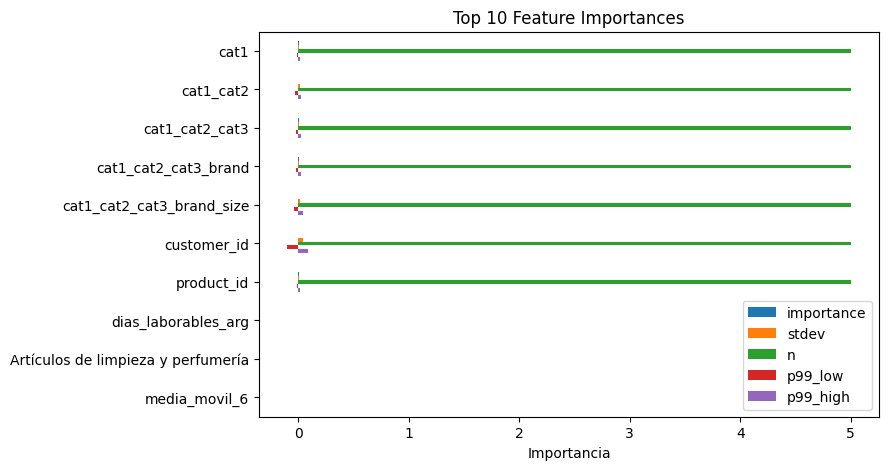

In [24]:
# Extraemos la importancia de variables usando el método de AutoGluon:
importances = predictor.feature_importance(ts_df)

# Mostramos las top 10 variables más importantes (puedes ajustar el número)
print(importances.head(10))

# Si quieres visualizarlo (opcional)
import matplotlib.pyplot as plt

importances.head(10).plot(kind='barh', figsize=(8,5))
plt.title('Top 10 Feature Importances')
plt.xlabel('Importancia')
plt.gca().invert_yaxis()
plt.show()

### predecir con autogluon

In [26]:
# Obtenemos los IDs únicos de todas las series que queremos predecir
unique_item_ids = ts_df.item_ids

# Creamos las fechas futuras para las que necesitamos las covariables
future_timestamps = pd.to_datetime(["2020-01", "2020-02"])

# Construimos el DataFrame
future_known_covariates_list = []
for item_id in unique_item_ids:
    # Aquí es donde pondrías los valores REALES o ESTIMADOS para el futuro.
    # Por ejemplo, podrías tener un archivo con las proyecciones económicas.
    # Para este ejemplo, los inventaremos.
    future_data_for_item = pd.DataFrame({
        item_id_col: item_id,
        timestamp_col: future_timestamps,
        "dias_laborables_arg": [22, 20], # Valores para Ene y Feb 2020
        "anio": [2020, 2020],
        "mes": [1, 2],
        'secuencia': [1, 2],
        'trimestre': [1, 1],
        "cisne_negro": [0, 0],            # No hay eventos especiales planeados
        "periodo":[37,38]
    })
    future_known_covariates_list.append(future_data_for_item)

future_known_covariates_df = pd.concat(future_known_covariates_list)

print("\nDataFrame con las covariables conocidas para el período de predicción:")
#print(future_known_covariates_df)


DataFrame con las covariables conocidas para el período de predicción:


In [27]:
# ===================================================================
# 7. REALIZAR LA PREDICCIÓN
# ===================================================================
# Al llamar a predict, le pasamos los datos de entrenamiento (para que sepa desde dónde empezar)
# y el DataFrame con las covariables futuras que acabamos de crear.
predictions = predictor.predict(
    ts_df,
    known_covariates=future_known_covariates_df
)

print("\nPredicciones completas (incluyendo cuantiles):")
#print(predictions)

data with frequency 'MS' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble



Predicciones completas (incluyendo cuantiles):


In [28]:
# ===================================================================
# 8. FILTRAR EL RESULTADO DESEADO
# ===================================================================
# La predicción nos da los 2 meses. Filtremos para ver solo Febrero 2020.
predictions_febrero_2020 = predictions.filter(like="2020-02", axis=0)

print("\n\n===== PREDICCIÓN FINAL PARA FEBRERO 2020 =====")
# La columna 'mean' contiene la predicción puntual más probable.
#print(predictions_febrero_2020[['mean']])



===== PREDICCIÓN FINAL PARA FEBRERO 2020 =====


In [29]:
type(predictions_febrero_2020)

autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame

### maniobrando para volver

In [30]:
df_pred = pd.DataFrame(predictions_febrero_2020['mean'])
df_pred = df_pred.reset_index()
df_pred.head()

,item_id,timestamp,mean
0,20118_10012,2020-02-29,4.635
1,20012_10075,2020-02-29,0.005
2,20004_10279,2020-02-29,0.122
3,20002_10001,2020-02-29,174.584
4,20106_10004,2020-02-29,6.635


## manioboro para sacar la predicción

In [31]:
# creo la columna product_id como los cinco primeros caracteres de la columna item_id de df_pred
df_pred['product_id'] = df_pred['item_id'].str[:5]
df_pred.head()

,item_id,timestamp,mean,product_id
0,20118_10012,2020-02-29,4.635,20118
1,20012_10075,2020-02-29,0.005,20012
2,20004_10279,2020-02-29,0.122,20004
3,20002_10001,2020-02-29,174.584,20002
4,20106_10004,2020-02-29,6.635,20106


In [32]:
# obtengo df_pred1 como la suma de mean para cada timestamp y cada product_id
df_pred1 = df_pred.groupby(['product_id', 'timestamp'])['mean'].sum().reset_index()
df_pred1.head()

,product_id,timestamp,mean
0,20001,2020-02-29,911.062
1,20002,2020-02-29,704.580
2,20003,2020-02-29,484.408
3,20004,2020-02-29,367.408
4,20005,2020-02-29,356.271


In [33]:
# llevo la columna timestamp a formato period[M]
df_pred1['timestamp'] = pd.to_datetime(df_pred1['timestamp'])
df_pred1['timestamp'] = df_pred1['timestamp'].dt.to_period('M')
df_pred1.head()

,product_id,timestamp,mean
0,20001,2020-02,911.062
1,20002,2020-02,704.580
2,20003,2020-02,484.408
3,20004,2020-02,367.408
4,20005,2020-02,356.271


In [34]:
df_pred1.shape

(882, 3)

In [35]:
df_pred1.dtypes

,0
product_id,object
timestamp,period[M]
mean,float64


In [36]:
#llevo la columna product_id de df_pred1 a integrer
df_pred1['product_id'] = df_pred1['product_id'].astype(int)
df_pred1.dtypes

,0
product_id,int64
timestamp,period[M]
mean,float64


In [37]:
productos_validar.head()

,product_id
0,20001
1,20002
2,20003
3,20004
4,20005


In [38]:
productos_validar.shape

(780, 1)

In [39]:
productos_validar.dtypes

,0
product_id,int64


In [40]:
# Merge para obtener el promedio solo para los product_id que están en productos_validar
df_validar = productos_validar.merge(
    df_pred1,
    on='product_id',
    how='left'
)

# Ahora df_validar_promedio tendrá dos columnas: product_id y tn_prom_2018
print(df_validar.head())

   product_id timestamp     mean
0       20001   2020-02  911.062
1       20002   2020-02  704.580
2       20003   2020-02  484.408
3       20004   2020-02  367.408
4       20005   2020-02  356.271


In [41]:
df_validar.tail()

,product_id,timestamp,mean
775,21263,NaT,NaN
776,21265,NaT,NaN
777,21266,NaT,NaN
778,21267,NaT,NaN
779,21276,NaT,NaN


In [42]:
df_validar.shape

(780, 3)

In [43]:
# llevo al formato deseado, dropeo timestamp
df_validar_promedio = df_validar.drop(columns=['timestamp'])
df_validar_promedio.head()

,product_id,mean
0,20001,911.062
1,20002,704.580
2,20003,484.408
3,20004,367.408
4,20005,356.271


In [44]:
# le cambio el nombre de mean a tn
df_validar_promedio.rename(columns={'mean': 'tn'}, inplace=True)
df_validar_promedio.head()

,product_id,tn
0,20001,911.062
1,20002,704.580
2,20003,484.408
3,20004,367.408
4,20005,356.271


In [45]:
df_validar_promedio.to_csv(DATOS_DIR +'df_cluster123_auto_V3.csv', index=False)